<a href="https://colab.research.google.com/github/agape1225/BITCOIN-AUTO-TRADE-SERVER/blob/main/BITCOIN_AUTO_TRADE_%EB%8B%A4%EC%B0%A8%EC%9B%90_%ED%95%99%EC%8A%B5_%EB%B0%8F_%EB%8B%A4%EC%B0%A8%EC%9B%90_%EA%B2%B0%EA%B3%BC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [66]:
import os
import pandas as pd
import numpy as np
import math
import datetime as dt
import matplotlib.pyplot as plt

# For Evalution we will use these library

from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score, r2_score
from sklearn.metrics import mean_poisson_deviance, mean_gamma_deviance, accuracy_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# For model building we will use these library

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import LSTM


# For PLotting we will use these library

import matplotlib.pyplot as plt
from itertools import cycle
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

import matplotlib.pyplot as plt

In [116]:
# 데이터 불러오기
maindf = pd.read_csv('BTC_KRW.csv')
maindf = maindf.iloc[::-1]

# 필요한 열 선택
closedf = maindf[['시가', '종가', '고가', '저가', '거래량']]

# 데이터 전처리
closedf['종가'] = closedf['종가'].str.replace(',', '').astype(float)
closedf['시가'] = closedf['시가'].str.replace(',', '').astype(float)
closedf['고가'] = closedf['고가'].str.replace(',', '').astype(float)
closedf['저가'] = closedf['저가'].str.replace(',', '').astype(float)
closedf['거래량'] = closedf['거래량'].str.replace('K', '').astype(float)

<ipython-input-116-4078aebaaefa>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  closedf['종가'] = closedf['종가'].str.replace(',', '').astype(float)
<ipython-input-116-4078aebaaefa>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  closedf['시가'] = closedf['시가'].str.replace(',', '').astype(float)
<ipython-input-116-4078aebaaefa>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the document

In [117]:
# 데이터 정규화
scaler = MinMaxScaler(feature_range=(0, 1))
closedf = scaler.fit_transform(closedf)

# 데이터 분할
training_size = int(len(closedf) * 0.60)
test_size = len(closedf) - training_size
train_data, test_data = closedf[0:training_size, :], closedf[training_size:len(closedf), :]

In [118]:
# 시계열 데이터셋 생성 함수
def create_dataset(dataset, time_step=1, target_num=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - time_step - target_num):
        a = dataset[i:(i+time_step), :]
        b = dataset[i + time_step : i + time_step + target_num, 1]

        dataX.append(a)
        dataY.append(b)

        #print(a)
        #print(b)

    return np.array(dataX), np.array(dataY)

# 시계열 데이터셋 생성
time_step = 60
target_num = 15
X_train, y_train = create_dataset(train_data, time_step, target_num)
X_test, y_test = create_dataset(test_data, time_step, target_num)

In [119]:
# 데이터의 차원을 3차원으로 변경
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2])
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2])

In [120]:
# LSTM 모델 정의 및 학습
model = Sequential()
model.add(LSTM(20, input_shape=(X_train.shape[1], X_train.shape[2]), activation="tanh"))
model.add(Dense(target_num))
model.compile(loss="mean_squared_error", optimizer="adam")

history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=300, batch_size=512, verbose=1)

Epoch 1/300
3/3 [==============================] - 3s 386ms/step - loss: 0.0255 - val_loss: 0.2721
Epoch 2/300
3/3 [==============================] - 0s 38ms/step - loss: 0.0221 - val_loss: 0.2425
Epoch 3/300
3/3 [==============================] - 0s 39ms/step - loss: 0.0191 - val_loss: 0.2159
Epoch 4/300
3/3 [==============================] - 0s 34ms/step - loss: 0.0166 - val_loss: 0.1917
Epoch 5/300
3/3 [==============================] - 0s 21ms/step - loss: 0.0144 - val_loss: 0.1697
Epoch 6/300
3/3 [==============================] - 0s 27ms/step - loss: 0.0125 - val_loss: 0.1496
Epoch 7/300
3/3 [==============================] - 0s 28ms/step - loss: 0.0109 - val_loss: 0.1313
Epoch 8/300
3/3 [==============================] - 0s 21ms/step - loss: 0.0095 - val_loss: 0.1145
Epoch 9/300
3/3 [==============================] - 0s 22ms/step - loss: 0.0083 - val_loss: 0.0993
Epoch 10/300
3/3 [==============================] - 0s 23ms/step - loss: 0.0073 - val_loss: 0.0856
Epoch 11/300
3/3 [

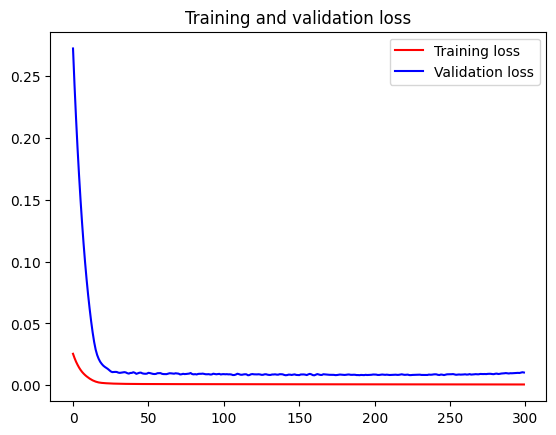

In [121]:
# 학습 과정 시각화
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)
plt.show()

In [122]:
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)
#print(X_train.shape)
X_train.shape, X_test.shape, train_predict.shape, test_predict.shape

27/27 [==============================] - 0s 7ms/step


((1303, 60, 5), (845, 60, 5), (1303, 15), (845, 15))

In [123]:
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)
original_ytrain = scaler.inverse_transform(y_train.reshape(-1,1))
original_ytest = scaler.inverse_transform(y_test.reshape(-1,1))
#print(test_predict)

ValueError: operands could not be broadcast together with shapes (1303,15) (5,) (1303,15) 

In [ ]:
print("Train data R2 score:", r2_score(original_ytrain, train_predict))
print("Test data R2 score:", r2_score(original_ytest, test_predict))

In [ ]:
model.save("BITCOIN_MODEL_VER2.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
from google.colab import drive

drive.mount('/content/drive')  # mounts the drive

Mounted at /content/drive
